In [1]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
import xinvert
import warnings
warnings.filterwarnings("ignore")

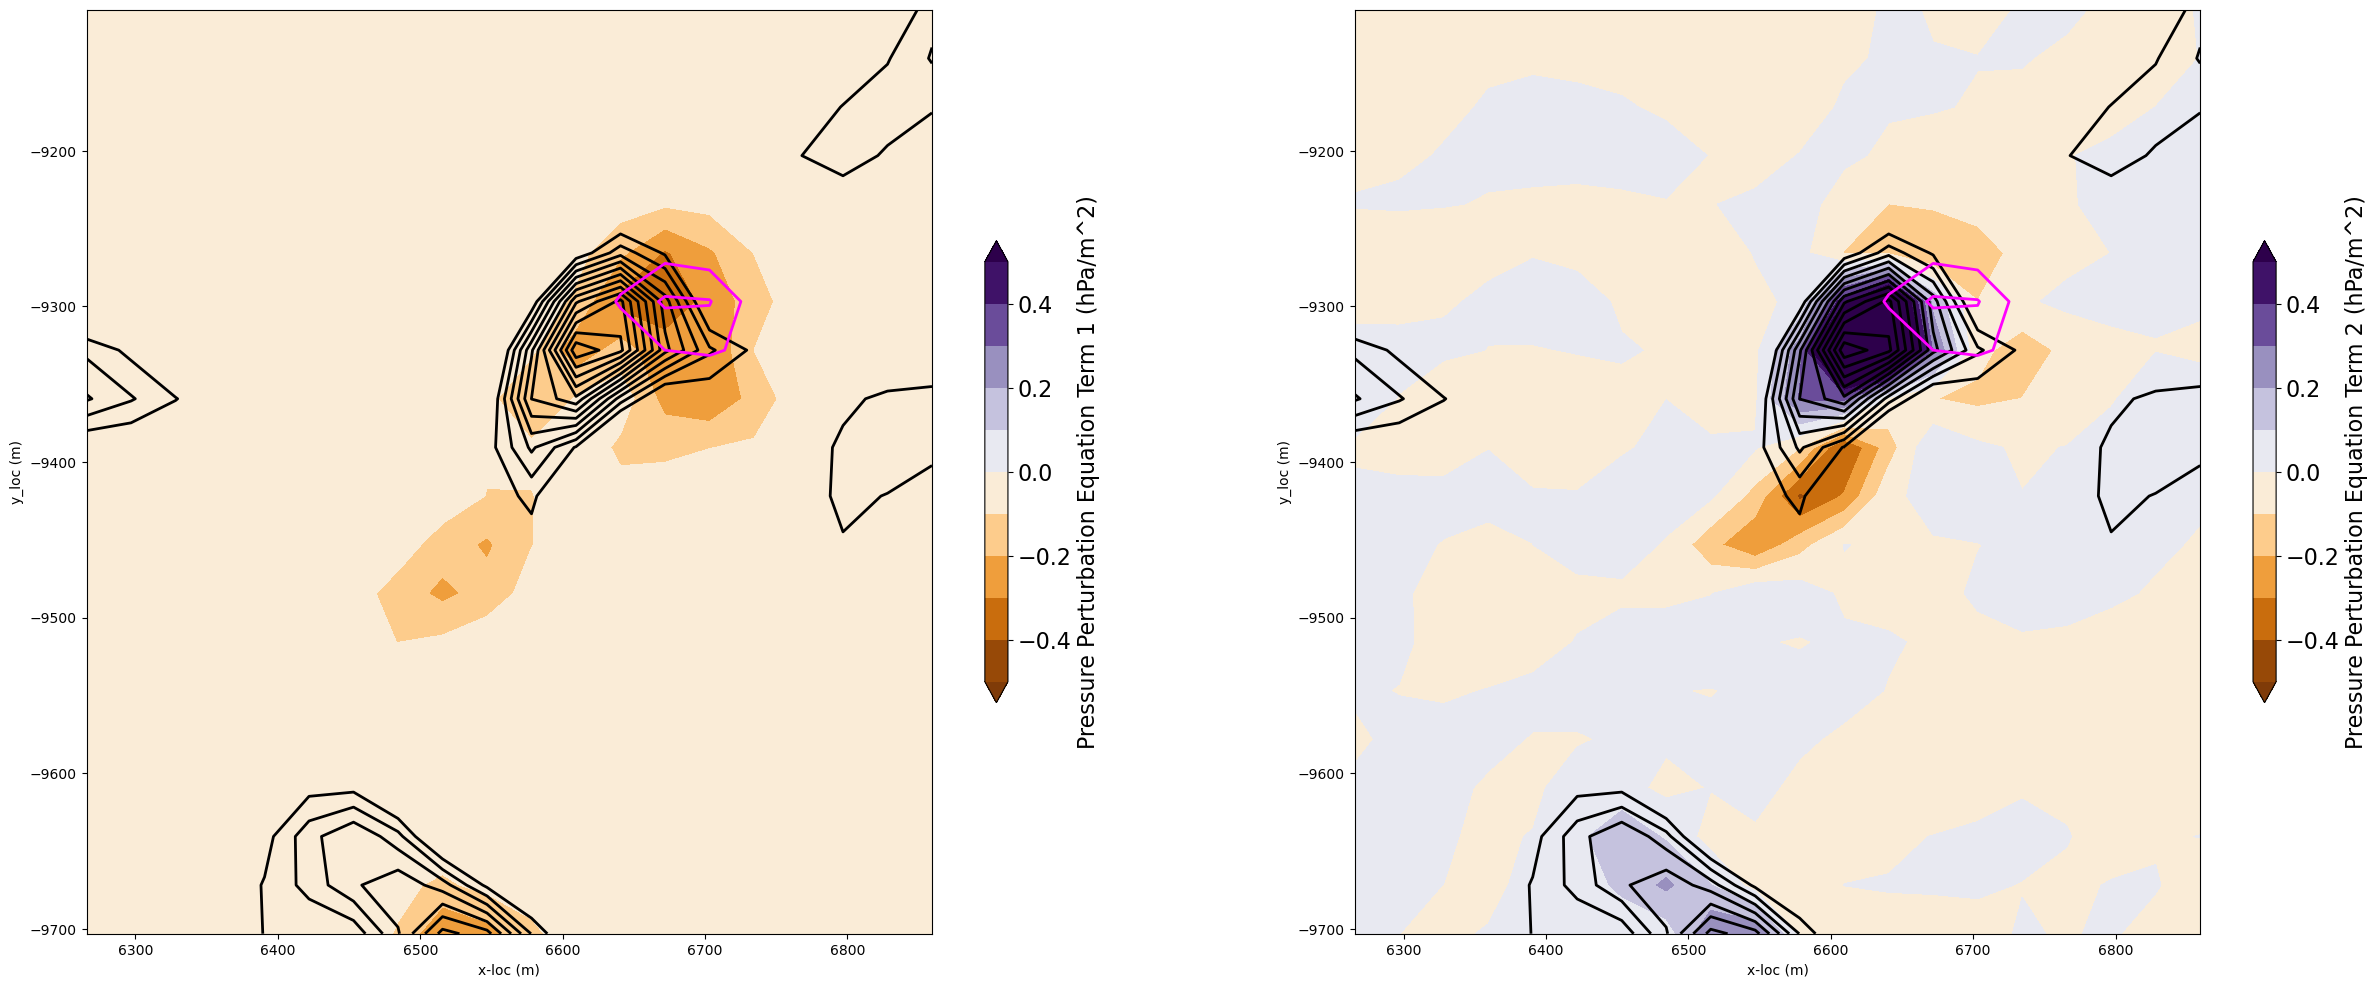

In [2]:
ds = xr.open_dataset('cm1_original/cm1out_20000101.000008.nc').isel(time=0)
ds = ds.isel(ni=slice(1000,1020),nj=slice(489,509))
time = ds.time.values
u = ds['u']
v = ds['v']
w = ds['w']
dx = ds['xh']*units('m')
dy = ds['yh']*units('m')
dz = ds['zh']*units('m')
p = ds['prs']
theta = ds['th']
q = ds['qv'] + ds['qc'] + ds['qr']
t = mpcalc.temperature_from_potential_temperature(pressure=p, potential_temperature=theta)
roh = mpcalc.density(pressure=p, temperature=t, mixing_ratio=q)
dudx = mpcalc.vector_derivative(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0], return_only = 'du/dx')
dvdy = mpcalc.vector_derivative(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0], return_only = 'dv/dy')
dwdz = mpcalc.vector_derivative(u, w, dx=dx[1]-dx[0], dy=dz[1]-dz[0], return_only = 'dv/dy')
dvdx = mpcalc.vector_derivative(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0], return_only = 'dv/dx')
dudy = mpcalc.vector_derivative(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0], return_only = 'du/dy')
dwdx = mpcalc.vector_derivative(u, w, dx=dx[1]-dx[0], dy=dz[1]-dz[0], return_only = 'dv/dx')
dwdy = mpcalc.vector_derivative(u, w, dx=dx[1]-dx[0], dy=dy[1]-dy[0], return_only = 'dv/dy')
dudz = mpcalc.vector_derivative(u, w, dx=dx[1]-dx[0], dy=dz[1]-dz[0], return_only = 'du/dy')
dvdz = mpcalc.vector_derivative(u, v, dx=dx[1]-dx[0], dy=dz[1]-dz[0], return_only = 'dv/dy')
zeta = mpcalc.vorticity(u, v, dx=dx[1]-dx[0], dy=dy[1]-dy[0])
term1 = -roh*((dudx)**2+(dvdy)**2+(dwdz)**2)
term2 = -2*roh*((dudy*dvdx)+(dudz*dwdx)+(dvdz*dwdy))
fig = plt.figure(figsize=(30,12))
ax1 = fig.add_subplot(1,2,1)
CF = ax1.contourf(dx, dy, term1.isel(nk=0), levels=np.arange(-.5, .6, .1), cmap='PuOr', extend='both')
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Pressure Perturbation Equation Term 1 (hPa/m^2)',fontsize=16)
CL1 = ax1.contour(dx, dy, zeta.isel(nk=0), levels=np.arange(.2, 2, .1), linewidths=2, colors='k')
CL2 = ax1.contour(dx, dy, w.isel(nk=0), colors='fuchsia', linewidths=2, levels=np.arange(5, 40, 2))
ax1.set_xlabel('x-loc (m)')
ax1.set_ylabel('y_loc (m)')
ax2 = fig.add_subplot(1,2,2)
CF = ax2.contourf(dx, dy, term2.isel(nk=0), levels=np.arange(-.5, .6, .1), cmap='PuOr', extend='both')
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Pressure Perturbation Equation Term 2 (hPa/m^2)',fontsize=16)
CL1 = ax2.contour(dx, dy, zeta.isel(nk=0), levels=np.arange(.2, 2, .1), linewidths=2, colors='k')
CL2 = ax2.contour(dx, dy, w.isel(nk=0), colors='fuchsia', linewidths=2, levels=np.arange(5, 40, 2))
ax2.set_xlabel('x-loc (m)')
ax2.set_ylabel('y_loc (m)')
tl1 = 'Zeta (1/s): black, w (m/s): pink'
tl2 = str(time)[14:19]
title_line = (tl1 + '\n' + tl2 + '\n');

In [3]:
term1 = term1.isel(nk=0)
term1 = term1*units('m^3')*units('s^2')*units('1/kg')

In [16]:
from xinvert import invert_Poisson
iParams = {
    'BCs'      : ['fixed', 'fixed'],
    'mxLoop'   : 1000,
    'tolerance': 1e-12,
}
sf = invert_Poisson(term1, dims=['nj','ni'], iParams=iParams)

{} loops 1000 and tolerance is 1.538794e-08


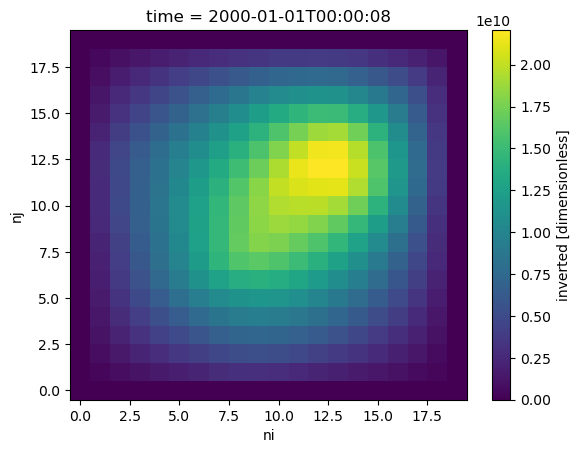

In [17]:
sf.plot()

In [18]:
term2 = term2.isel(nk=0)
term2 = term2*units('m^3')*units('s^2')*units('1/kg')

ValueError: Dimensions {'nk'} do not exist. Expected one or more of ('nj', 'ni')

In [23]:
from xinvert import invert_Poisson
iParams = {
    'BCs'      : ['fixed', 'fixed'],
    'mxLoop'   : 1000,
    'tolerance': 1e-12,
}
sf = invert_Poisson(term2, dims=['nj','ni'], iParams=iParams)

{} loops 1000 and tolerance is 1.901455e-08


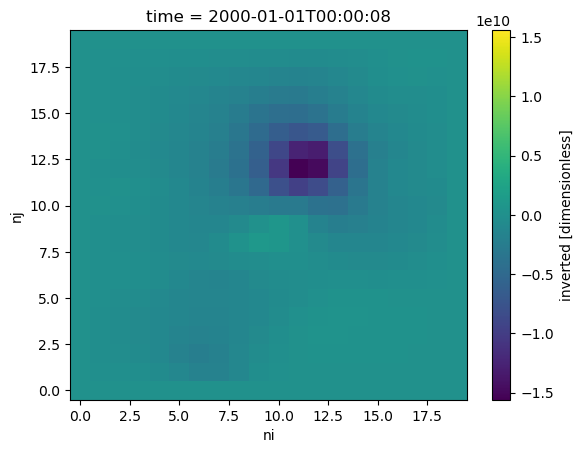

In [24]:
sf.plot(cmap='viridis')

In [ ]:
# test sensitivity (stability of perturbation pressure) to differetn grid sizes (extend by 20 grid points in ezch direction, then more and more)